## 1. Install VGG Image Annotator
http://www.robots.ox.ac.uk/~vgg/software/via/

## 2. Configure locally
- run the local HTML version
- set up project by sourcing image dir(s) to be labeled; configure project filename
- set up labels like this:
<img src="vgg_config.png" width="200"/>
- in settings you can change to display the label above each box (sanity check)
- can also set it so the radio button pops up right next to the box after you create/select it
- go through and label all the images
- periodically save and export your labels as json

## 3. Split files

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pathlib
import shutil
import cv2
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# change this to your main directory of raw images
# verify that inside the structure has the three subdirectories listed with the below structure
raw_img_root = '/home/schoder_m/crop-weed-bucket/raw_images/'

dirs = {'sugarcane':'raw_class_images/sugarcane', 
        'weeds':'raw_class_images/weeds',
        'joint':'SugarcaneWeeds'}
data_dirs = {x: pathlib.Path(raw_img_root + dirs[x]) for x in dirs.keys()}
img_counts = {x: len(list(data_dirs[x].glob('*.jpg'))) for x in dirs.keys()}
for x in dirs.keys():
    print(f'%s images: %d'%(x, img_counts[x]))
    
    
# Shuffle files - seed to make it consistent
np.random.seed(32)
file_lists = {x: sorted(list(data_dirs[x].glob('*.jpg'))) for x in dirs.keys()}
for x in dirs.keys():
    np.random.shuffle(file_lists[x])

sugarcane images: 869
weeds images: 856
joint images: 415


In [7]:
# desired image counts
label_counts = {'sugarcane': 100,
               'weeds': 100,
               'joint': 200}
label_paths = {x: file_lists[x][:label_counts[x]] for x in dirs.keys()}

files_a = {x: label_paths[x][:len(label_paths[x])//2] for x in dirs.keys()}
files_b = {x: label_paths[x][len(label_paths[x])//2:] for x in dirs.keys()}

## 4. Copy files to a new directory (careful, do this once)

In [ ]:
# Mike --> files_a; Cody --> files_b (change this below)

# input your destination directory. set up three empty subdirs: 'sugarcane', 'weeds, 'joint'

In [ ]:
# Randomly select a fixed number of images from each directory
dest_dir = '/Users/mschoder/weeding_project/box_label_task_b'

for x in dirs.keys():
    for file in files_b[x]:
        shutil.copyfile(file, dest_dir+'/'+x+'/'+file.name)


## 5. Post-Labeling -- Merge Labels into single file

In [ ]:
labels_a_path = './labels_a.json'
labels_b_path = './labels_b.json'

with open(labels_a_path) as f:
    labels_a = json.load(f)

with open(labels_b_path) as f:
    labels_b = json.load(f)

labels_a = labels_a['_via_img_metadata']
labels_b = labels_b['_via_img_metadata']

In [ ]:
# remove duplicate labeled images before merge
dupe_labels_b = set(labels_b) & set(labels_a)
for uk in dupe_labels_b:
    del labels_b[uk]
# Merge
labels_dict_tmp = {**labels_a, **labels_b}
print("Unique labeled images: ", len(labels_dict.keys()))

# clean keys as they are already unique on image filenames (presume ixxxx.jpg structure)
labels_dict = {}
for k,v in labels_dict_tmp.items():
    k_new = k[:9]
    labels_dict[k_new] = v

In [ ]:
# Verify no unlabeled images
for k,v in labels_dict.items():
    if (v['regions'] is None or len(v['regions']) == 0):
        print(k)

In [ ]:
# Example data structure
labels_dict['i2825.jpg']

In [ ]:
# write out to clean json
with open("labels.json", "w") as outfile:  
    json.dump(labels_dict, outfile) 

## 6. Match labeled files from raw images and copy into a new dir 
(since we messed up our labeling) 

In [ ]:
labeled_files = [v['filename'] for k,v in labels_dict.items()]
all_filepaths = file_lists['sugarcane'] + file_lists['weeds'] + file_lists['joint']

labeled_img_paths = [path for path in all_filepaths if path.name in set(labeled_files)]

In [ ]:
dest_dir = '/Users/mschoder/weeding_project/box_labeled_data/jpg_images'
for file in labeled_img_paths:
    shutil.copyfile(file, dest_dir+'/'+file.name)

## 7. Build separate dataset + labels for weed-only detections
(exclude sugarcane only images)

In [42]:
data_dir = '/Users/mschoder/weeding_project/box_labeled_data'
with open(os.path.join(data_dir, "labels.json")) as f:
            labels_dict = json.load(f)

weed_labels_dict = {}
for k,v in labels_dict.items():
    box_dict = v['regions']
    if 'weed' in set([x['region_attributes']['label'] for x in box_dict]):
        weed_labels_dict[k] = v
    
# write out to clean json
with open("weed_labels.json", "w") as outfile:  
    json.dump(weed_labels_dict, outfile) 
    

In [41]:
# Match corresponding images and save to the weeds_only dir
labeled_files = [v['filename'] for k,v in weed_labels_dict.items()]
all_filepaths = file_lists['weeds'] + file_lists['joint']
labeled_img_paths = [path for path in all_filepaths if path.name in set(labeled_files)]

for file in labeled_img_paths:
    shutil.copyfile(file, data_dir+'jpg_images_allweeds/'+file.name)

## Validate annotations
-Debugging issue with rotations

In [25]:
import os
from PIL import Image, ExifTags
import image_to_numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [39]:
# # on vm - copy img files
# data_dir = "/home/schoder_m/box_labeled_data"
# dest_path = pathlib.Path(data_dir) / "jpg_images_allweeds"
# labels_path = pathlib.Path(data_dir) / 'weed_labels.json'

# with open(labels_path) as f:
#     weed_labels_dict = json.load(f)

    
# # Match corresponding images and save to the weeds_only dir
# weed_labeled_files = [v['filename'] for k,v in weed_labels_dict.items()]
# all_filepaths = file_lists['weeds'] + file_lists['joint']
# labeled_img_paths = [path for path in all_filepaths if path.name in set(weed_labeled_files)]

# for file in labeled_img_paths:
#     shutil.copyfile(file, dest_path / file.name)

In [37]:
### DEBUG
# Access annotations directly
with open(os.path.join(data_dir, "weed_labels.json")) as f:
    annot = json.load(f)


In [38]:
annot['i2852.jpg']

{'filename': 'i2852.jpg',
 'size': 5343548,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 444,
    'y': 10,
    'width': 1866,
    'height': 1261},
   'region_attributes': {'label': 'sugarcane'}},
  {'shape_attributes': {'name': 'rect',
    'x': 66,
    'y': 1160,
    'width': 2658,
    'height': 2855},
   'region_attributes': {'label': 'sugarcane'}},
  {'shape_attributes': {'name': 'rect',
    'x': 358,
    'y': 3228,
    'width': 2633,
    'height': 1276},
   'region_attributes': {'label': 'sugarcane'}}],
 'file_attributes': {}}

{'filename': 'i2852.jpg', 'size': 5343548, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 444, 'y': 10, 'width': 1866, 'height': 1261}, 'region_attributes': {'label': 'sugarcane'}}, {'shape_attributes': {'name': 'rect', 'x': 66, 'y': 1160, 'width': 2658, 'height': 2855}, 'region_attributes': {'label': 'sugarcane'}}, {'shape_attributes': {'name': 'rect', 'x': 358, 'y': 3228, 'width': 2633, 'height': 1276}, 'region_attributes': {'label': 'sugarcane'}}], 'file_attributes': {}}
image shape:  42467328
x:  444
y:  10
xmax:  2310
ymax:  1271
x:  66
y:  1160
xmax:  2724
ymax:  4015
x:  358
y:  3228
xmax:  2991
ymax:  4504


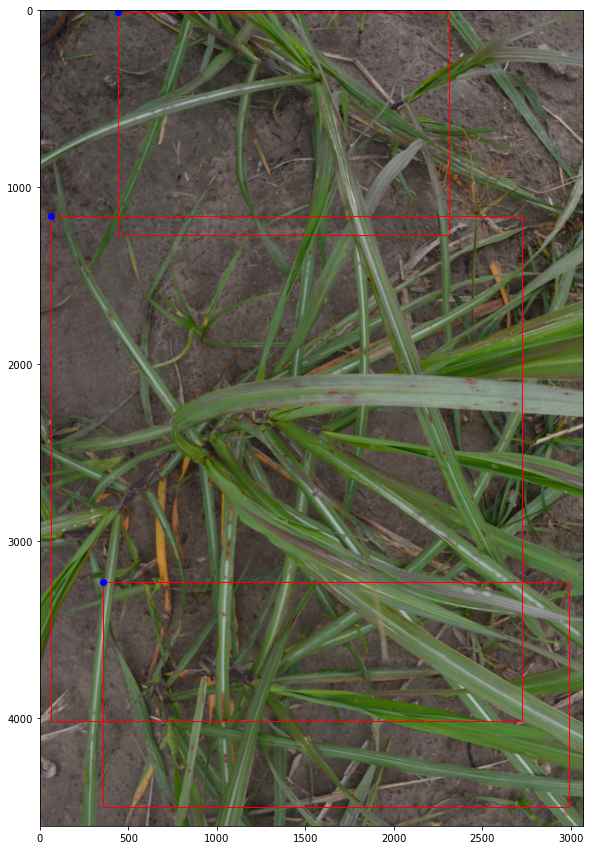

In [28]:
iff = 'i2831.jpg'
iff = 'i1271.jpg'
iff = 'i3230.jpg'
iff = 'i2852.jpg'

kan = annot[iff]
print(kan)

pth = '/home/schoder_m/box_labeled_data/jpg_images_allweeds/' + iff
img_raw = img = image_to_numpy.load_image_file(pth)
print("image shape: ", img_raw.size)



fig,ax = plt.subplots(1, figsize=(15,15))
plt.imshow(img_raw)
for i in range(len(kan['regions'])):
#     if i != 1: continue
    x = kan['regions'][i]['shape_attributes']['x']
    y = kan['regions'][i]['shape_attributes']['y']
    wd = kan['regions'][i]['shape_attributes']['width']
    ht = kan['regions'][i]['shape_attributes']['height']
    print("x: ", x)
    print("y: ", y)
    print("xmax: ", x+wd)
    print("ymax: ", y+ht)
    plt.plot([x], [y], 'bo')
    
    
    rect = patches.Rectangle((x,y), wd, ht, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [12]:
img.shape

(4608, 3072, 3)

In [13]:
type(img)

numpy.ndarray

In [14]:
image = Image.fromarray(img.astype('uint8'), 'RGB')

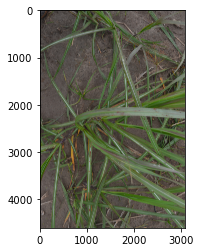

In [15]:
plt.imshow(image)